Submitters:
* Arthur Bražinskas
* Minh Ngo

# Lab 1: Independent Component Analysis

### Machine Learning 2: March 2016

* The lab exercises should be made in groups of two people.
* The deadline is Sunday, April 10, 23:59.
* Assignment should be sent to t.s.cohen at uva dot nl (Taco Cohen). The subject line of your email should be "[MLPM2016] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[MLPM2016] lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [26]:
%pylab inline

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, label=None):
    """
    Plot the signals contained in the rows of X.
    """
    fig = plt.figure()
    
    if label != None:
        fig.suptitle(label, fontsize=14)

    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        ax.plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


The following code generates some toy data to work with.

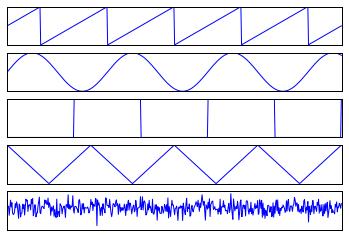

In [27]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$. 

In [28]:
def make_mixtures(S, A):
    """
    Algorithm 34.4: Step 1
    """
    return np.dot(A, S)

In [29]:
# Test
make_mixtures(S, random_nonsingular_matrix(d=len(S)))

array([[-0.19470585, -0.43995608, -0.43260551, ..., -0.12255169,
        -0.44165288,  1.38549595],
       [ 0.46543377,  0.2193773 ,  0.24608486, ...,  1.05572263,
         0.69406572,  1.22239569],
       [ 0.64550958,  0.39028424,  0.39548218, ...,  0.73063087,
         0.4245143 ,  1.54904104],
       [ 1.04595307,  0.872284  ,  0.86012946, ...,  1.39230831,
         1.2020645 ,  1.71328897],
       [ 0.47165288,  0.31733253,  0.33391022, ...,  1.03081373,
         0.83248849,  2.25387056]])

### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the numpy `histogram()` function. 

Plot histograms of the sources and the measurements. 
Which of these distributions (sources or measurements) tend to look more like Gaussians? Why is this important for ICA? Can you think of an explanation for this phenomenon?

In [30]:
def plot_histograms(X, labels):
    fig = plt.figure()
    fig.set_size_inches((16, 4))
    for i, (x, label) in enumerate(zip(X, labels)):
        ax = plt.subplot(1, len(X), i + 1)
        plt.title(label)
        plt.hist(x)
        
    plt.show()

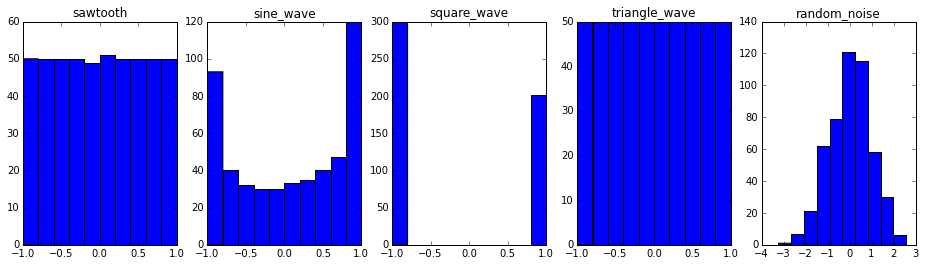

In [31]:
# Histogram of the source
plot_histograms(S, labels=['sawtooth', 'sine_wave', 'square_wave', 'triangle_wave', 'random_noise'])

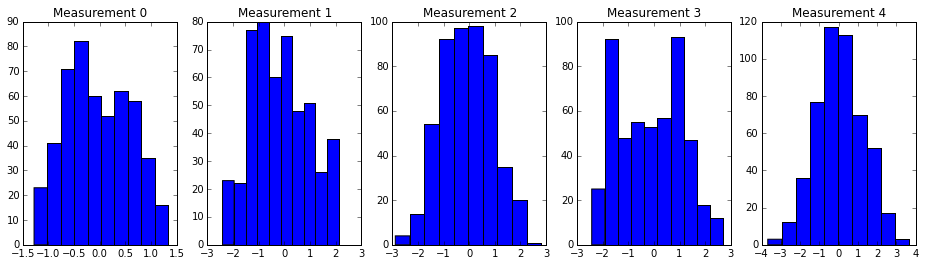

In [32]:
# Histogram of the measurement
A = random_nonsingular_matrix(d=len(S))
M = make_mixtures(S, A)
plot_histograms(M, labels=['Measurement %d' % d for d in range(5)])



## Question: Which of these distributions (sources or measurements) tend to look more like Gaussians? Why is this important for ICA? Can you think of an explanation for this phenomenon?
The last plot in sources and measurements very similar by the shape to the gaussian distributions. 
Due to the symmetric nature of the distribution , we cannot figure out the nature of the independent components. As the projections will not give us a good degree of information. In other words, if our data has gaussian distribution there is an arbitrary rotational component in the mixing matrix that cannot be determined from the data, and we cannot recover the original sources http://cs229.stanford.edu/notes/cs229-notes11.pdf.

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, derive the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

The normalizing constant **is not required**, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

Plot the activation functions and the corresponding prior distributions. Compare the shape of the priors to the histogram you plotted in the last question.

$$
p(a) = \exp\bigg(\int \phi_i(a)da \bigg)
$$

$$
p_0(a) = \exp\bigg(-\int tanh(a)da \bigg) \propto \exp\bigg(-\ln\cosh(a)\bigg) \propto \dfrac{1}{cosh(a)}
$$

$$
p_1(a) = \exp\bigg(-\int (a - tanh(a))da \bigg) \propto \exp\bigg(-\dfrac{1}{2}a^2 + \ln\cosh(a)\bigg) \propto \exp\bigg(-\dfrac{1}{2}a^2\bigg)cosh(a)
$$

$$
p_2(a) = \exp\bigg(-\int a^3da\bigg) \propto \exp\bigg(-\dfrac{1}{4}a^4\bigg)
$$

$$
p_3(a) = \exp\bigg(-\int \dfrac{6a}{a^2 + 5} da\bigg) \propto \exp\bigg(-3\ln(a^2+5)\bigg) \propto (a^2+5)^{-3}
$$

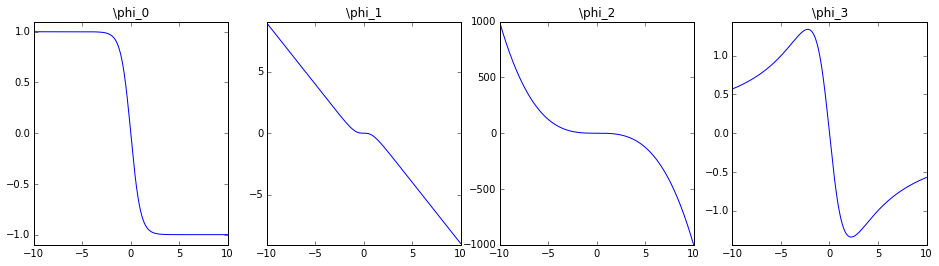

In [33]:
phi0 = lambda a: -np.tanh(a)
phi1 = lambda a: -a + np.tanh(a)
phi2 = lambda a: -a ** 3
phi3 = lambda a: -6 * a/ (a ** 2 + 5)

activation_functions = [phi0, phi1, phi2, phi3]

p0 = lambda a: 1 / np.cosh(a)
p1 = lambda a: np.exp(-0.5 * a ** 2) * np.cosh(a)
p2 = lambda a: np.exp(-0.25 * a ** 4)
p3 = lambda a: (a ** 2 + 5) ** (-3)

prior_dist = [p0, p1, p2, p3]

def plot_function(functions, labels):
    fig = plt.figure()
    fig.set_size_inches((16, 4))

    a = np.linspace(-10, 10, 1000)

    for i, (func, label) in enumerate(zip(functions, labels)):
        ax = plt.subplot(1, len(functions), i + 1)
        output = func(a)
        plt.plot(a, output)
        plt.title(label)
        ax.set_ylim((min(output) - 0.1, max(output) + 0.1))

    plt.show()

# Plotting activation functions
plot_function(activation_functions, ['\phi_0', '\phi_1', '\phi_2', '\phi_3'])

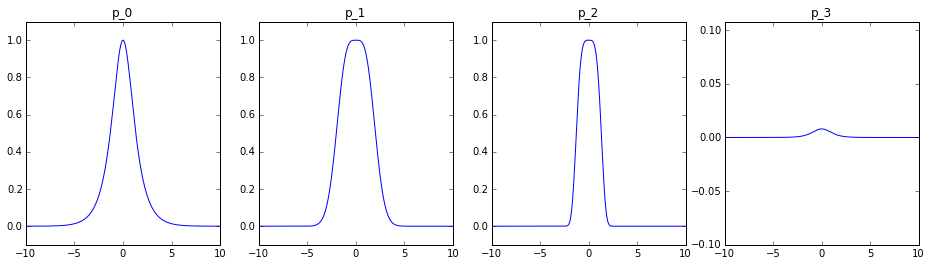

In [34]:
# Plotting corresponding prior distributions
plot_function(prior_dist, ['p_0', 'p_1', 'p_2', 'p_3'])

The first three distributions look by the shape like gaussians. On the other hand, they also look very similar to t-distributions
with peaks but with lighter tails. 

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf

In [35]:
def whiten(X):
    # Zero mean data
    X -= np.mean(X, axis=1, keepdims=True)
    
    # Covariance matrix of X
    Phi = np.cov(X)
    # Eigenvalues and eigenvectors
    Lamb, Phi = np.linalg.eigh(Phi)
    
    Lamb = np.diag(Lamb)
    A = Phi.dot(np.sqrt(np.linalg.inv(Lamb)))
    return A.T.dot(X)

In [36]:
M_whiten = whiten(M)

### 1.5 Interpret results of whitening (10 points)
Make scatter plots of the sources, measurements and whitened measurements. Each axis represents a source/measurement and each time-instance is plotted as a dot in this space. You can use the `np.scatter()` function. Describe what you see.

Now compute the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize a covariance matrix using the line of code below. Are the signals independent after whitening?

In [37]:
def plot_scatter(signals, labels):
    from itertools import product

    fig, axes = plt.subplots(nrows=len(signals), ncols=len(signals), figsize=(17, 10))

    for ax, col in zip(axes[0], labels):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], labels):
        ax.set_ylabel(row, rotation=90, size='large')
    
    for i, s0 in enumerate(signals):
        for j, s1 in enumerate(signals):
            axes[i][j].scatter(s0, s1)

    fig.tight_layout()
    plt.show()

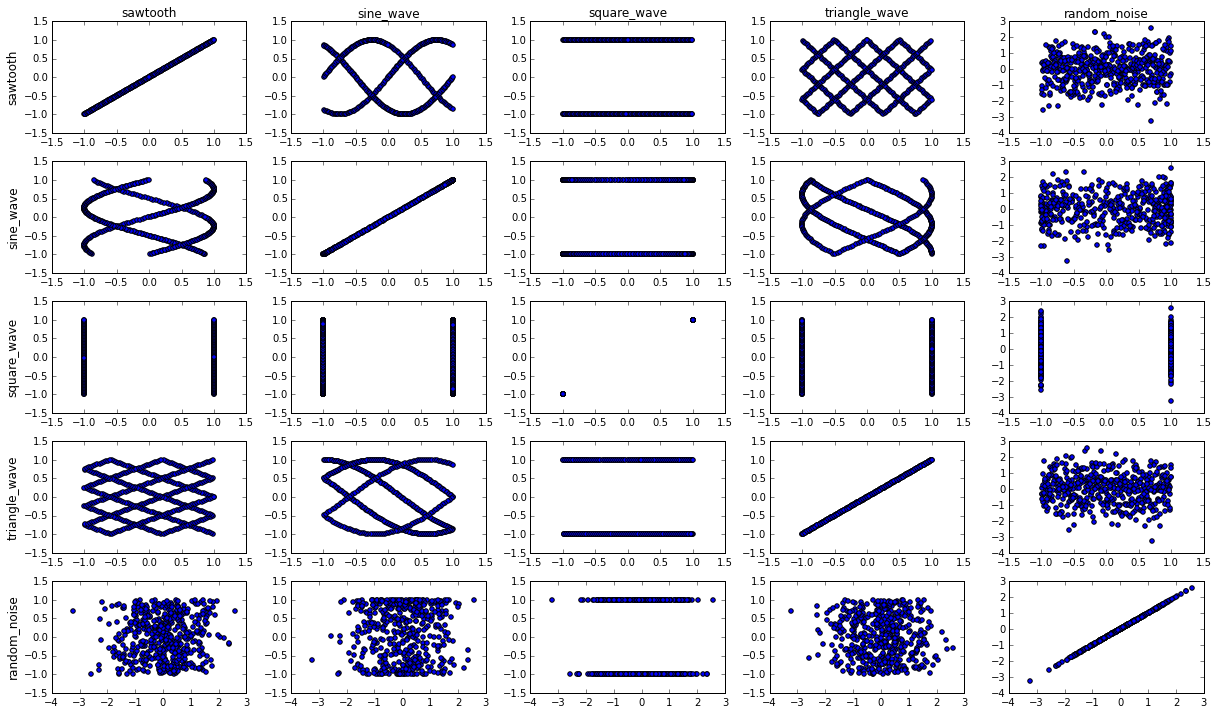

In [38]:
# Original signals scatter plot
plot_scatter(S, labels=['sawtooth', 'sine_wave', 'square_wave', 'triangle_wave', 'random_noise'])

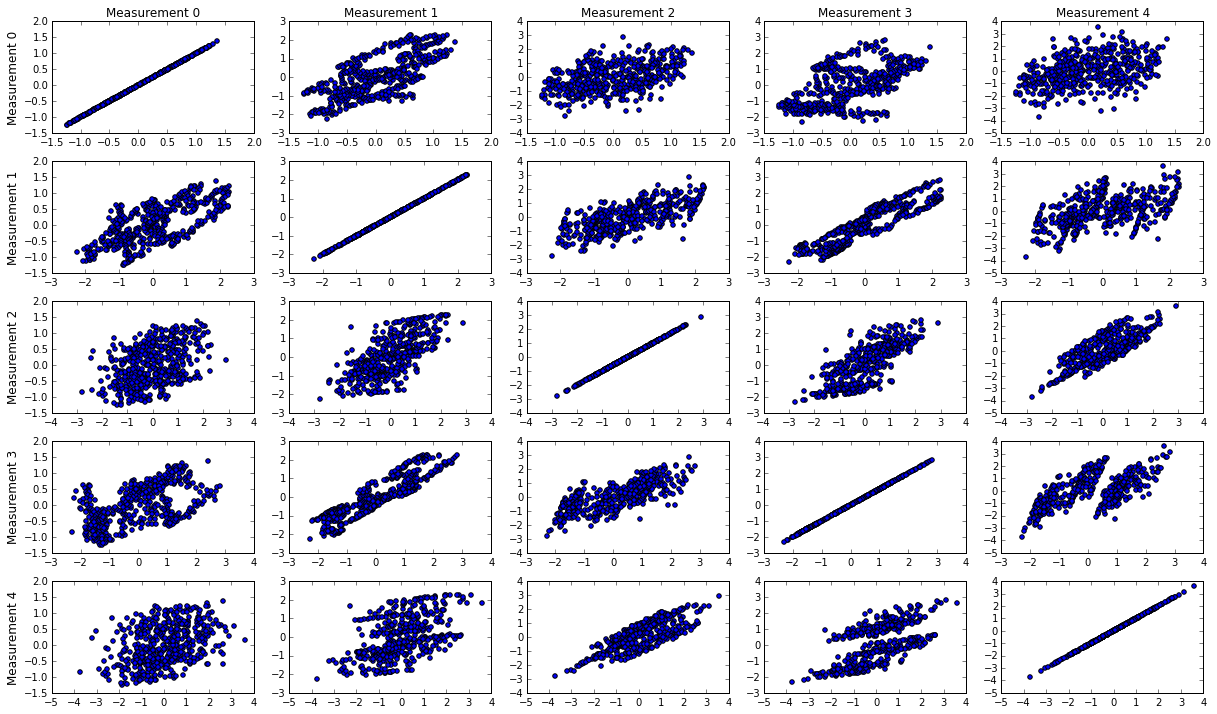

In [39]:
# Measurements scatter plot
plot_scatter(M, labels=['Measurement %d' % d for d in range(5)])

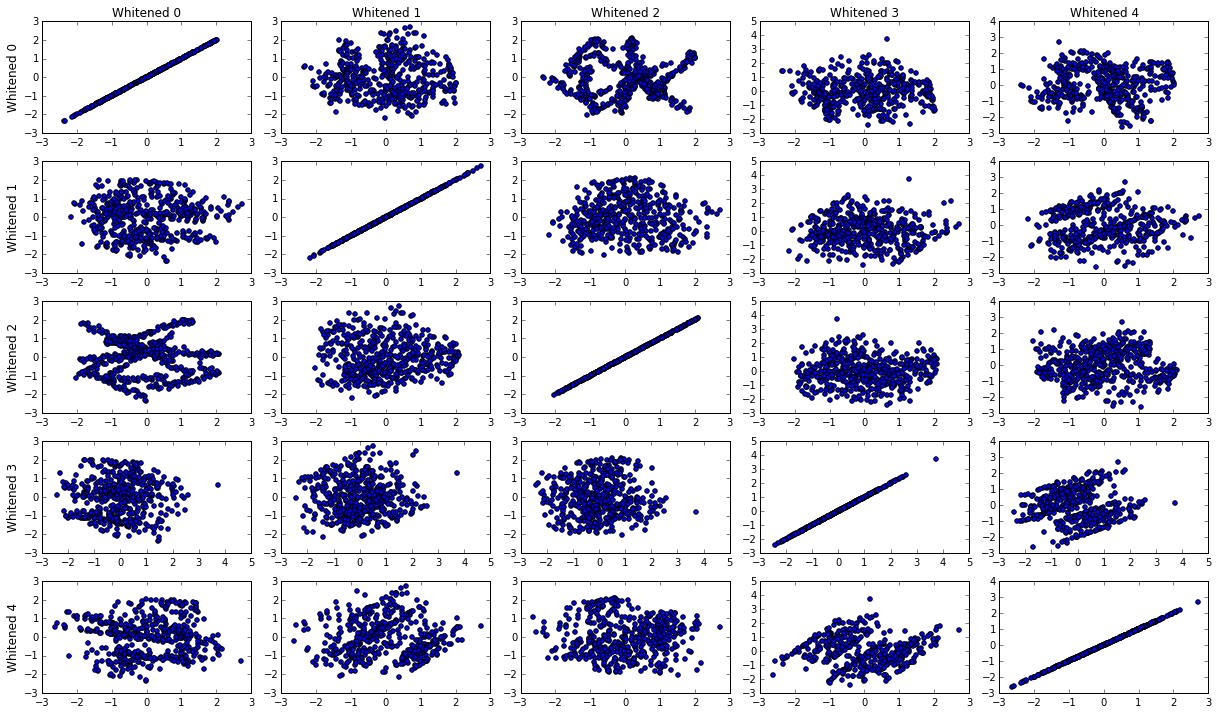

In [40]:
# Whitened measurements
plot_scatter(M_whiten, labels=['Whitened %d' % d for d in range(5)])

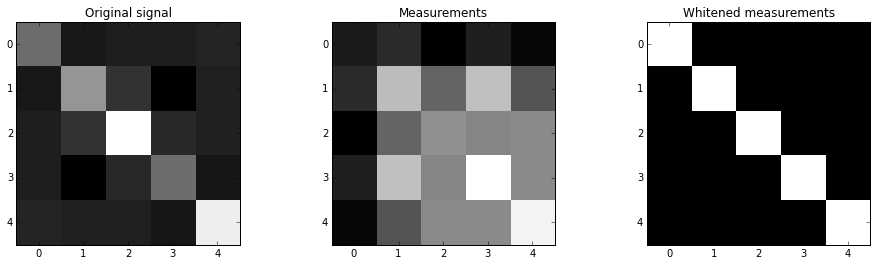

In [41]:
# Computing covariance matrices
fig = plt.figure()
fig.set_size_inches((16, 4))

cov_mats = map(np.cov, [S, M, whiten(M)])

labels = ['Original signal', 'Measurements', 'Whitened measurements']

for i, (C, label) in enumerate(zip(cov_mats, labels)):
    ax = plt.subplot(1, len(cov_mats), i + 1)
    plt.title(label)
    imshow(C, cmap='gray', interpolation='nearest')

plt.show()

After whitenning procedure the signals become uncorrelated but not independent. Two signals can have zero correlation but still be dependent, for example consider the following scenario http://mathforum.org/library/drmath/view/64808.html


### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

A covariant algorithm is an algorithm that returns the same result independently from the scale of quantities [MacKay (2002) "[Maximum Likelihood and Covariant Algorithms for Independent Componen t Analysis](http://www.inference.phy.cam.ac.uk/mackay/ica.pdf)", Section 3]. One of example of non-covariant algorithm is steepest
descents rule:

$$ \Delta w_i = \nu \dfrac{\partial L}{\partial w_i} $$

where L(w) is an objective function dependent on **w**, left and right hand sides have different dimensions of $[w_i]$ and $1/[w_i]$ that leads to non-covariant behavior against linear rescaling of the $w_i$ parameter. To make it covariant a multiplier matrix for the right hand side can be introduced that is dependent on curvatures and metrics.

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Try to make it efficient, i.e. use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code).

In [42]:
def ICA(X, activation_function, learning_rate, niter=100):
    W = random_nonsingular_matrix(d=len(X))
    
    # Algorithm 34.4 (MacKay)
    for i in range(niter):
        # 1st step. Put X through linear mapping
        a = W.dot(X)
        # 2nd step. Put a through nonlinear mapping
        z = activation_function(a)
        # 3rd step. Put a back trough W
        x_ = W.T.dot(a)
        # 4th step. Compute derivative
        dW = W + z.dot(x_.T) / X.shape[1]

        W += learning_rate * dW
    
    return W

### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$. Plot the retreived signals for each choice of activation function.

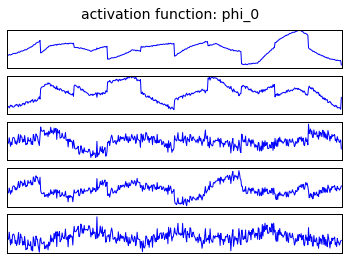

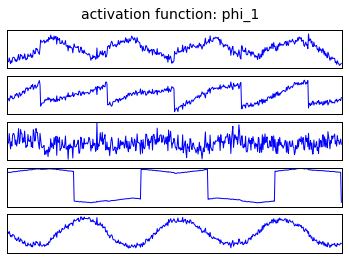

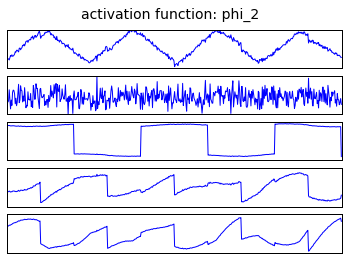

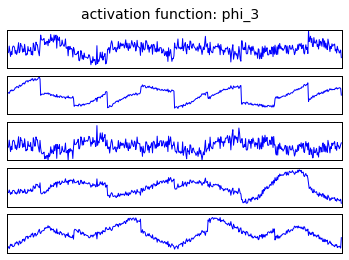

In [43]:
for idx, phi in enumerate(activation_functions):
    W = ICA(M_whiten, phi, 0.001, niter=10000)
    plot_signals(W.dot(M_whiten), label='activation function: phi_%d' % idx)

### 1.9 Audio demixing (5 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and produces 5 mixed sound files, which are saved to disk so you can listen to them. Use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions and report your results.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think ways to deal with these issues.

In [44]:
import scipy.io.wavfile
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

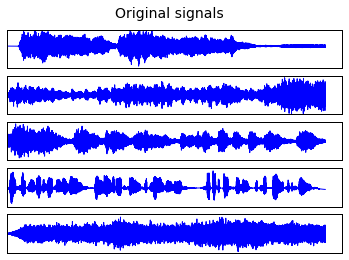

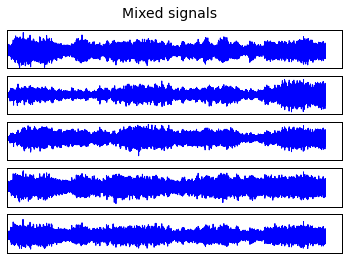

In [45]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S = np.c_[wav_data]
plot_signals(S, label='Original signals')

# Requires your function make_mixtures
X = make_mixtures(S, random_nonsingular_matrix(d=len(S)))
plot_signals(X, label='Mixed signals')
# Save mixtures to disk, so you can listen to them in your audio player
for i in range(X.shape[0]):
    save_wav(X[i, :], 'X' + str(i) + '.wav', sample_rate)

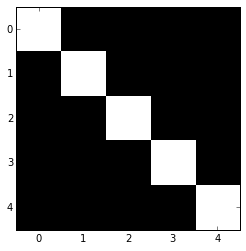

In [46]:
X_whiten = whiten(X)
imshow(np.cov(X_whiten), cmap='gray', interpolation='nearest')
plt.show()
W = ICA(X_whiten, phi3, 0.01, niter=10000)

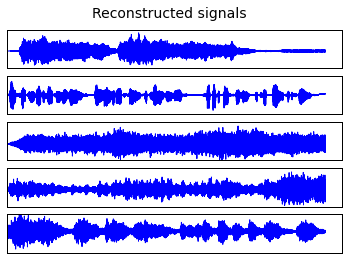

In [47]:
R = W.dot(X_whiten)
plot_signals(R, label='Reconstructed signals')

In [48]:
for i in range(R.shape[0]):
    save_wav(R[i, :], 'R' + str(i) + '.wav', sample_rate)

### 1.10 Excess Kurtosis (20 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. To do this, you will need the normalizing constant of the distribution, which you can either obtain analytically (good practice!), using computer algebra software (e.g. Sage) or by numerical integration (see scipy.integrate).


Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals. Can you use this data to explain the performance of the various activation functions?

##Answer

$$p(a) = cosh^{-1}(a) ~~~  \int_{-\infty}^{\infty} p(x) dx = \pi$$
Thus the valid pdf has the following form: $$f(x) = \frac{1}{\pi cosh(x)}$$

$$EX = \int_{-\infty}^{\infty} \frac{x}{cosh(x) \pi} dx = 0$$
$$EX^2 = \int_{-\infty}^{\infty} \frac{x^2}{cosh(x) \pi} dx  = \frac{\pi^2}{4}$$
$$Var(X) = E[(X-\mu)^2] = EX^2 - (EX)^2  = \pi^2/4$$

$$E[(X-\mu)^4] = E[X^4] = \int_{-\infty}^{\infty} \frac{x^4}{cosh(x) \pi} dx  = \frac{5\pi^4}{16}$$

Now we can compute the kurtosis as follows:

$$Kurt(X) = \frac{E[(X-\mu)^4]}{E[(X-\mu)^2]^2} - 3 = \frac{5 \pi^4 16}{16 \pi^4} - 3 = 2 $$






$$ p(a) = cosh(a) e^{(-\frac{a^2}{2})} $$ 

$$ \int_{-\infty}^{\infty} p(a) da = \sqrt{2e\pi} $$, so the valid pdf has a the form:
$$ f(x) = \frac{cosh(x) e^{-\frac{x^2}{2} }}{\sqrt{2e\pi}}  $$ 

$$EX = \int_{-\infty}^{\infty} \frac{x~cosh(x)~e^{-\frac{x^2}{2} }}{\sqrt{2e\pi}}dx = 0 $$
$$EX^2 = \int_{-\infty}^{\infty} \frac{x^2~cosh(x)~e^{-\frac{x^2}{2} }}{\sqrt{2e\pi}}dx = 2$$
$$Var(X) = E[(X-\mu)^2] =2 $$
$$E[(X-\mu)^4] = E[X^4] = 10$$
$$Kurt(X) = \frac{10}{4}-3 = -0.5 $$



$$p(a) = e^{-\frac{a^4}{4}} ~and~ \int_{-\infty}^{\infty} p(a) da = \frac{\Gamma(\frac{1}{4}) } {\sqrt2}$$ Thus the valid pdf has the form:

$$ f(x) = \frac{\sqrt 2 }{\Gamma(\frac{1}{4}) e^({\frac{x^4}{4}})}$$

$$EX = 0   $$
$$EX^2 \approx 0.6759 $$
$$Var(X) = E[(X-\mu)^2] \approx 0.6759$$
$$E[(X-\mu)^4] = E[X^4] =  1 $$
$$Kurt(X) \approx -0.8111 $$

In [49]:
import scipy.stats
# Dummy signals
DS = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
A = random_nonsingular_matrix(d=len(S))
M = make_mixtures(DS, A)

print scipy.stats.kurtosis(M, fisher=True, axis=1)

# Real audio signals
X = make_mixtures(S, random_nonsingular_matrix(d=len(S)))
print scipy.stats.kurtosis(X, fisher=True, axis=1)

[-1.09317997 -0.57607133 -0.8159776  -0.3377     -0.51850077]
[ 0.40762675  0.62706207  0.51221426  1.02569719  0.79766887]


$$p(a) = (a^2+5)^{-3}, ~and ~ \int_{-\infty}^{\infty} p(a) da = \frac{3\pi}{200 \sqrt{5} }$$ Thus the valid pdf is: 

$$f(x) = \frac{200 \sqrt5}{3\pi} (x^2+5)^{-3}$$

$$ E[(X-\mu)^2] = \frac{5}{3}$$

$$ E[(X-\mu)^4] =  25 $$

$$Kurt(X) = \frac{25 * 9}{25}- 3 = 6$$

In [50]:
import scipy.stats
# real data
S1 = np.c_[wav_data]
X1 = make_mixtures(S1,random_nonsingular_matrix(d=len(S)))

# artificial data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S2 = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T


kurt1 = [2,-0.5,-0.811,6]
kurt2 = scipy.stats.kurtosis(S1,axis=1,fisher=True)
kurt3 = scipy.stats.kurtosis(S2,axis=1,fisher=True)
kurt4 = scipy.stats.kurtosis(X1,axis=1,fisher=True)

print('theoretical kurtosis: '+str(kurt1))
print('kurtosis of the real data (source): '+str(kurt2))
print('kurtosis of the real data (observed): '+str(kurt4))
print('kurtosis of the artificial data (source): '+str(kurt3))

theoretical kurtosis: [2, -0.5, -0.811, 6]
kurtosis of the real data (source): [ 1.79431517  2.06885064  1.93609295  5.05191721  0.53887581]
kurtosis of the real data (observed): [ 1.53270021  1.07175356  0.71906821  1.26832257  0.88992085]
kurtosis of the artificial data (source): [-1.19640244 -1.48287113 -1.84019701 -1.2000384  -0.13685533]


The positive kurtosis indicates how thick (heavy) are tails of distributions, for example Expo(1) has kurtosis =6 and Pois(4) 0.25. There is a debate if peakness of distributions is associated with kurtosis and some sources state that it's not the case, e.g. https://en.wikipedia.org/wiki/Kurtosis. Therefore, we going to use the fact about thick tails only in the further discussion. 

We can see that real data source signals have positive kurtosis (as well as observed data X), and we can interpret that summary as presence of outliers that can be e.g. more than 3 standard diviation away from the mean. Intuitively, we would like to use an activation function that has an underlying distribution more suitable for outlier presence, e.g. t-distribution is stable for extreme data points. 

To prove our hypothesis, we ran 10,000 iterations with 0.01 learning rate to obtain demixed audio signals such that we could compare applications of different activation functions. As we observed activation functions with positive kurtosis, i.e $\phi_0$ and $\phi_3$ perform merely perfect demixing, while other two leave noise and sounds from other sources. Please see the demixed folder. 

It can be indicated that we have obtained Kurtosis closed to zero for random signal (Gaussian random variables have zero kurtosis). The negative kurtosis typically indicates a flat pdf (like uniform) (Hyvärinen et al. (1999) [Independent Component Analysis: A Tutorial](http://www.stat.ucla.edu/~yuille/courses/Stat161-261-Spring14/HyvO00-icatut.pdf)) that is peculiar to other artificial signals (sawtooth, [sine_wave](http://atif-razzaq.blogspot.nl/2011/02/probability-density-function-pdf-of.html), square_wave, triangle_wave).

It's important to note that the same analysis can be addapted to the case when source signals are not known in advance, and only mixed X matrix is in order to chose proper activation functions.